In [2]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [3]:
df1 = pd.read_stata(fpath + "/full_data_6yr.dta")
df1 = df1[df1.valid == 0]
df1.loc[:,'first_gen_0'] = df1.phe_1 + df1.phe_2 + df1.phe_3
df1.loc[:,'first_gen_1'] = df1.phe_4 + df1.phe_5 + df1.phe_6 + df1.phe_7
for v in ['term_cred_att_', 'enrolled_']:
    df1.loc[:,v+"sum"] = 0
    for t1 in ['sp','su','fa']:
        for t2 in range(1,7):
            t = t1+str(t2)
            df1.loc[:,v+"sum"] = df1.loc[:,v+"sum"] + df1.loc[:,v+t]
df1.loc[:,'avg_cred_att'] = df1.term_cred_att_sum / df1.enrolled_sum
df1.loc[:,'pct_enrolled'] = df1.enrolled_sum / 18

In [4]:
df2 = pd.read_stata(fpath + "/full_data_truncated.dta")
df2 = df2[df2.valid == 1]
df2.loc[:,'first_gen_0'] = df2.phe_1 + df2.phe_2 + df2.phe_3
df2.loc[:,'first_gen_1'] = df2.phe_4 + df2.phe_5 + df2.phe_6 + df2.phe_7
for v in ['term_cred_att_', 'enrolled_', 'available_']:
    df2.loc[:,v+"sum"] = 0
    for t1 in ['sp','su','fa']:
        for t2 in range(1,7):
            t = t1+str(t2)
            df2.loc[:,v+"sum"] = df2.loc[:,v+"sum"] + df2.loc[:,v+t]
df2.loc[:,'avg_cred_att'] = df2.term_cred_att_sum / df2.enrolled_sum
df2.loc[:,'pct_enrolled'] = df2.enrolled_sum / df2.available_sum

In [5]:
df = pd.concat([df1,df2], join='inner')

##### **Note: This model variant only includes 13 predictors, which are all simple non-term-specific predictors

In [8]:
predictors = ['male', 'afam', 'white', 'hisp', 'other', 'first_gen_0', 'first_gen_1', 'cum_gpa', 'pct_enrolled', 'avg_cred_att', 'prop_comp', 'pell_0_ind', 'pell_1_ind']
print(len(predictors))
impute_list_3 = set(["cum_gpa", "prop_comp"])

13


In [9]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(300144, 329) (33115, 329)


In [10]:
def impute(train, test):
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test               

In [11]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_simple_predictors_2\\no_truncation"

In [13]:
def create_cv_folds(train, n_fold = 5):
    folds = []
    k_fold = KFold(n_splits = n_fold, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        folds.append([(X_1.copy(),y_1.copy()),(X_2.copy(),y_2.copy())])
    return folds

In [14]:
five_folds = create_cv_folds(train_df)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
def cross_validation_RF(rf_model, folds):
    auc_by_fold = []
    for f in folds:
        X_1 = f[0][0]
        y_1 = f[0][1]
        X_2 = f[1][0]
        y_2 = f[1][1]
        rf_model.fit(X_1,y_1)
        y_2_pred = rf_model.predict_proba(X_2)[:,1]
        auc_by_fold.append(roc_auc_score(y_2,y_2_pred))
    return round(np.mean(auc_by_fold),4)  

In [16]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(5,21):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto")
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(10,21),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

Max_depth = 5
Mean CV AUC: 0.8555

Max_depth = 6
Mean CV AUC: 0.859

Max_depth = 7
Mean CV AUC: 0.8618

Max_depth = 8
Mean CV AUC: 0.8642

Max_depth = 9
Mean CV AUC: 0.8662

Max_depth = 10
Mean CV AUC: 0.8678

Max_depth = 11
Mean CV AUC: 0.869

Max_depth = 12
Mean CV AUC: 0.8699

Max_depth = 13
Mean CV AUC: 0.8704

Max_depth = 14
Mean CV AUC: 0.8706

Max_depth = 15
Mean CV AUC: 0.8702

Max_depth = 16
Mean CV AUC: 0.8695

Max_depth = 17
Mean CV AUC: 0.8684

Max_depth = 18
Mean CV AUC: 0.8669



KeyboardInterrupt: 

In [20]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=11,
                                random_state=0, n_jobs=20, max_features="auto")
    auc = cross_validation_RF(rf, five_folds)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

Number of Trees = 100
Mean CV AUC: 0.8689

Number of Trees = 120
Mean CV AUC: 0.8689

Number of Trees = 140
Mean CV AUC: 0.8689

Number of Trees = 160
Mean CV AUC: 0.869



KeyboardInterrupt: 

Max_features = 1
Mean CV AUC: 0.8646

Max_features = 2
Mean CV AUC: 0.8669

Max_features = 3
Mean CV AUC: 0.8689

Max_features = 4
Mean CV AUC: 0.8702

Max_features = 5
Mean CV AUC: 0.8706

Max_features = 6
Mean CV AUC: 0.8709

Max_features = 7
Mean CV AUC: 0.8709



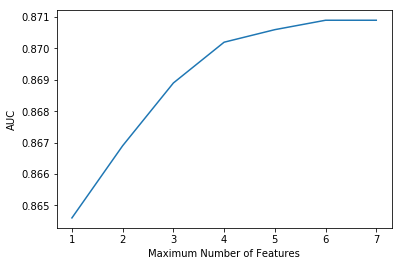

In [21]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(1,max_nf+1):
    rf = RandomForestClassifier(n_estimators=100, criterion="entropy", 
                                max_depth=11,
                                random_state=0, n_jobs=20, max_features=nf)
    auc = cross_validation_RF(rf, five_folds)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(1,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

In [22]:
rf = RandomForestClassifier(n_estimators=100, criterion="entropy",
                            max_depth=11,
                            random_state=0, n_jobs=20, max_features=4)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=20,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
print("Random Forest:")
print("AUC = {}".format(round(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]),4)))
y_test_pred_rf = rf.predict_proba(X_test)[:,1]

Random Forest:
AUC = 0.8163


In [24]:
# pickle.dump(rf, open(results_dir + "/rf.p", "wb"))
pickle.dump(list(y_test_pred_rf), open(results_dir + "/y_test_pred_rf.p", "wb"))

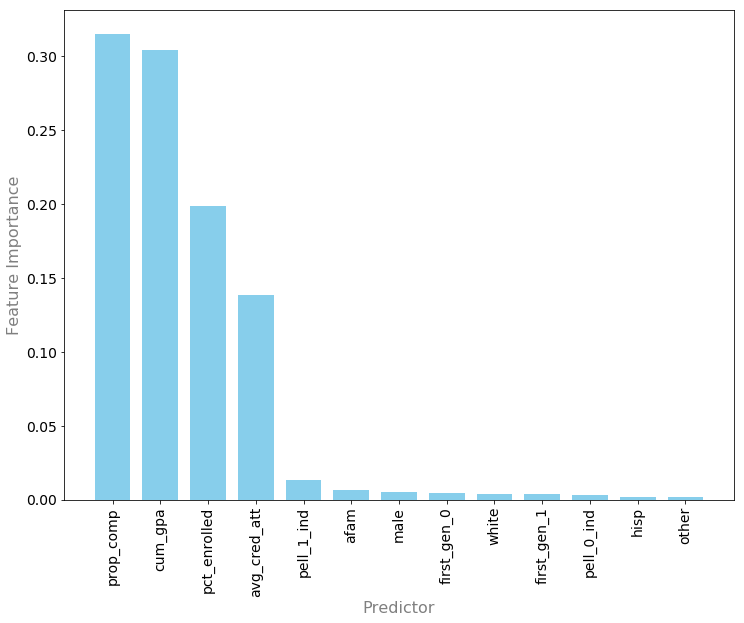

In [25]:
xx = np.array(predictors)[np.argsort(rf.feature_importances_)[::-1]][:20]
yy = rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1]][:20]
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(13)),yy, width=0.75, color = "skyblue")
plt.xticks(list(range(13)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16,color="gray")
plt.ylabel("Feature Importance", fontsize=16,color="gray")
plt.savefig(results_dir + "RF_variable_importance.png", bbox_inches="tight")
plt.show()

In [27]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, model):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        model.fit(X_1,y_1)
        if type(model) != sklearn.linear_model.base.LinearRegression:
            p,r,t = precision_recall_curve(y_2, model.predict_proba(X_2)[:,1])
            auc = roc_auc_score(y_2, model.predict_proba(X_2)[:,1])
        else:
            p,r,t = precision_recall_curve(y_2, model.predict(X_2))
            auc = roc_auc_score(y_2, model.predict(X_2))
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)   

In [28]:
best_threshold = cross_validation(train_df,rf)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.870183101322232 0.0016942080072666012


In [29]:
best_threshold

0.4149131380233573

In [31]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [32]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_rf = create_confusion_matrix(y_test_pred_rf, best_threshold, "RF_cm1")

F1 threshold = 0.415:

         Pred_0   Pred_1         
Real_0  12208.0   9600.0  21808.0
Real_1   1255.0  10052.0  11307.0
        13463.0  19652.0  33115.0

F1 score = 0.6494


In [33]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred_rf)[:num_of_0]] = 0
alternative_threshold = y_test_pred_rf[np.argsort(y_test_pred_rf)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_rf = create_confusion_matrix(y_test_pred_binary, best_threshold, "RF_cm2")

Alternative threshold = 0.688:

         Pred_0   Pred_1         
Real_0  17746.0   4062.0  21808.0
Real_1   3897.0   7410.0  11307.0
        21643.0  11472.0  33115.0

F1 score = 0.6506


In [34]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_rf,(alternative_threshold,)+pr2_rf]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "RF_precision_recall.csv", index=True)